## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

## Loading Dataset

In [2]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="data", train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:25<00:00, 386kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 81.0kB/s]
100%|██████████| 1.65M/1.65M [00:04<00:00, 357kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.54MB/s]


In [4]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

## Creating Data Loader

In [6]:
train_loader = DataLoader(
    train_data,
    batch_size=10,
    shuffle=True
)

test_loader = DataLoader(
    test_data,
    batch_size=10,
    shuffle=False
)

## Setting Convolutional Layers

In [7]:
conv1 = nn.Conv2d(
    in_channels=1,
    out_channels=6,
    kernel_size=3,
    stride=1
)

conv2 = nn.Conv2d(
    in_channels=6,
    out_channels=16,
    kernel_size=3,
    stride=1
)

## Checking Data

In [8]:
for i, (X_train, y_train) in enumerate(train_data):
  break

In [9]:
X_train.shape

torch.Size([1, 28, 28])

In [10]:
x = X_train.view(1, 1, 28, 28)

## Passing Data through Layers

In [11]:
x = F.relu(conv1(x))

In [12]:
x.shape

torch.Size([1, 6, 26, 26])

In [13]:
x = F.max_pool2d(input=x, kernel_size=2, stride=2)

In [14]:
x.shape

torch.Size([1, 6, 13, 13])

In [15]:
x = F.relu(conv2(x))

In [16]:
x.shape

torch.Size([1, 16, 11, 11])

In [17]:
x = F.max_pool2d(input=x, kernel_size=2, stride=2)

In [18]:
x.shape

torch.Size([1, 16, 5, 5])

In [19]:
x.view(-1, 16*5*5).shape

torch.Size([1, 400])

## Creating Model

In [20]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(in_features=5*5*16, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(input=X, kernel_size=2, stride=2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(input=X, kernel_size=2, stride=2)
        X = X.view(-1, 16*5*5)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

## Training the Model

In [21]:
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [22]:
parameter_list = []
for param in model.parameters():
    parameter_list.append(param.numel())

print(f"Total Number of Parameters: {sum(parameter_list)}")

Total Number of Parameters: 60074


In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [24]:
import time
start_time = time.time()

epochs = 5
train_losses_list = []
test_losses_list = []
train_correct_list = []
test_correct_list = []

for i in range(epochs):
    train_correct = 0
    test_correct = 0

    for batch, (X_train, y_train) in enumerate(train_loader):
        batch += 1
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        batch_correct = (predicted == y_train).sum()
        train_correct += batch_correct

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 600 == 0:
            print(f"EPOCH: {i} BATCH: {batch} LOSS: {loss.item()}")

    train_losses_list.append(loss.detach().numpy())
    train_correct_list.append(train_correct)

    # Testing
    with torch.no_grad():
        for batch, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            test_correct += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses_list.append(loss.detach().numpy())
    test_correct_list.append(test_correct)


current_time = time.time()
total_time = current_time - start_time
print(f"Training Took {total_time/60} minutes")

EPOCH: 0 BATCH: 600 LOSS: 0.5472213625907898
EPOCH: 0 BATCH: 1200 LOSS: 0.05642206594347954
EPOCH: 0 BATCH: 1800 LOSS: 0.09080065786838531
EPOCH: 0 BATCH: 2400 LOSS: 0.5778023600578308
EPOCH: 0 BATCH: 3000 LOSS: 0.30019131302833557
EPOCH: 0 BATCH: 3600 LOSS: 0.06526441127061844
EPOCH: 0 BATCH: 4200 LOSS: 0.025572827085852623
EPOCH: 0 BATCH: 4800 LOSS: 0.027147049084305763
EPOCH: 0 BATCH: 5400 LOSS: 0.039440352469682693
EPOCH: 0 BATCH: 6000 LOSS: 0.038349539041519165
EPOCH: 1 BATCH: 600 LOSS: 0.12731114029884338
EPOCH: 1 BATCH: 1200 LOSS: 0.2930057942867279
EPOCH: 1 BATCH: 1800 LOSS: 0.0022583783138543367
EPOCH: 1 BATCH: 2400 LOSS: 0.10719206184148788
EPOCH: 1 BATCH: 3000 LOSS: 0.005425791256129742
EPOCH: 1 BATCH: 3600 LOSS: 0.6947051286697388
EPOCH: 1 BATCH: 4200 LOSS: 0.01516732107847929
EPOCH: 1 BATCH: 4800 LOSS: 0.0017803877126425505
EPOCH: 1 BATCH: 5400 LOSS: 0.04167879372835159
EPOCH: 1 BATCH: 6000 LOSS: 0.38114917278289795
EPOCH: 2 BATCH: 600 LOSS: 0.0058719683438539505
EPOCH: 2 

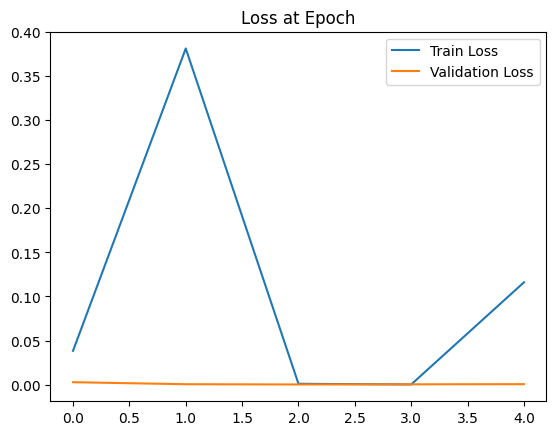

In [25]:
plt.plot(train_losses_list, label='Train Loss')
plt.plot(test_losses_list, label='Validation Loss')
plt.title("Loss at Epoch")
plt.legend();

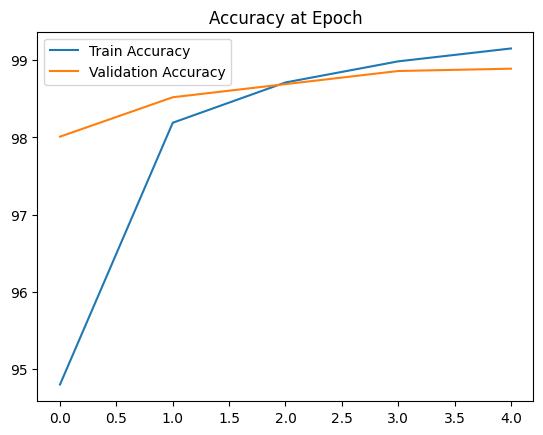

In [26]:
plt.plot([train/600 for train in train_correct_list], label='Train Accuracy')
plt.plot([test/100 for test in test_correct_list], label='Validation Accuracy')
plt.title("Accuracy at Epoch")
plt.legend();

## Evaluate Test Data

In [27]:
test_load_all = DataLoader(
    dataset=test_data,
    batch_size=10000,
    shuffle=False
)

In [28]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val.data, 1)[1]
        correct += (predicted == y_test).sum()

In [29]:
correct.item() / 10000

0.9889

In [30]:
print(classification_report(y_true=predicted.view(-1), y_pred=y_test.view(-1)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1133
           2       0.99      0.99      0.99      1038
           3       0.99      0.98      0.99      1025
           4       0.99      0.99      0.99       980
           5       0.98      0.99      0.98       879
           6       0.99      0.99      0.99       956
           7       0.98      0.99      0.99      1023
           8       1.00      0.98      0.99       991
           9       0.98      0.99      0.98       995

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



<Axes: >

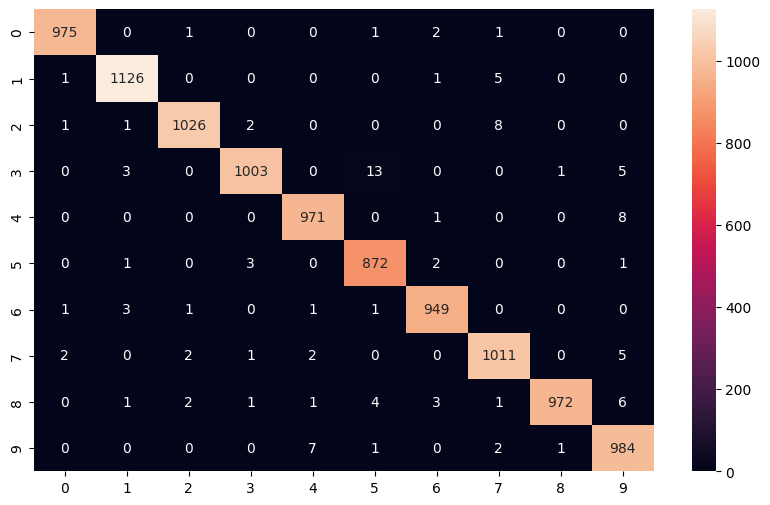

In [31]:
plt.figure(figsize=(10,6))
matrix = confusion_matrix(y_true=predicted.view(-1), y_pred=y_test.view(-1))
sns.heatmap(matrix, annot=True, fmt='1.0f')

## Predicting on Single Image

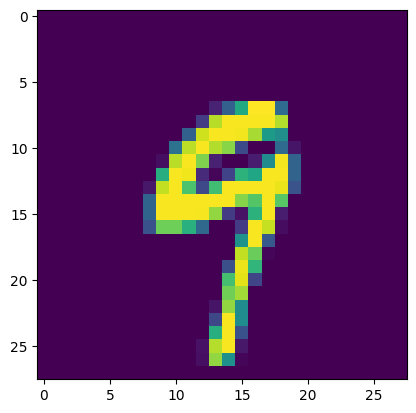

In [32]:
plt.imshow(test_data[2019][0].reshape(28, 28))

In [33]:
model.eval()

with torch.no_grad():
    single_image_prediction = model(test_data[2019][0].view(1, 1, 28, 28))

In [34]:
single_image_prediction.argmax()

tensor(9)